Imports

In [28]:
import matplotlib.pyplot as plt
import numpy as np

import jax
import jax.numpy as jnp
import jax.scipy.stats as stats

import blackjax

In [15]:
from datetime import date
rng_key = jax.random.key(int(date.today().strftime("%Y%m%d")))

In [16]:
print(rng_key)

Array((), dtype=key<fry>) overlaying:
[       0 20251106]


In [17]:
loc, scale = 10, 20
observed = np.random.normal(loc, scale, size=1_000)

In [18]:
def logdensity_fn(loc, log_scale, observed=observed):
    """Univariate Normal"""
    scale = jnp.exp(log_scale)
    logjac = log_scale
    logpdf = stats.norm.logpdf(observed, loc, scale)
    return logjac + jnp.sum(logpdf)


logdensity = lambda x: logdensity_fn(**x)

In [23]:
inv_mass_matrix = np.array([0.5, 0.01])
num_integration_steps = 60
step_size = 1e-3

hmc = blackjax.hmc(logdensity, step_size, inv_mass_matrix, num_integration_steps)

In [20]:
initial_position = {"loc": 1.0, "log_scale": 1.0}
initial_state = hmc.init(initial_position)
initial_state

HMCState(position={'loc': 1.0, 'log_scale': 1.0}, logdensity=Array(-34143.684, dtype=float32), logdensity_grad={'loc': Array(1170.8667, dtype=float32, weak_type=True), 'log_scale': Array(63452.48, dtype=float32, weak_type=True)})

In [24]:
hmc_kernel = jax.jit(hmc.step)


In [25]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [26]:
%%time
rng_key, sample_key = jax.random.split(rng_key)
states = inference_loop(sample_key, hmc_kernel, initial_state, 10_000)

mcmc_samples = states.position
mcmc_samples["scale"] = jnp.exp(mcmc_samples["log_scale"]).block_until_ready()

CPU times: user 2.99 s, sys: 145 ms, total: 3.14 s
Wall time: 2.22 s


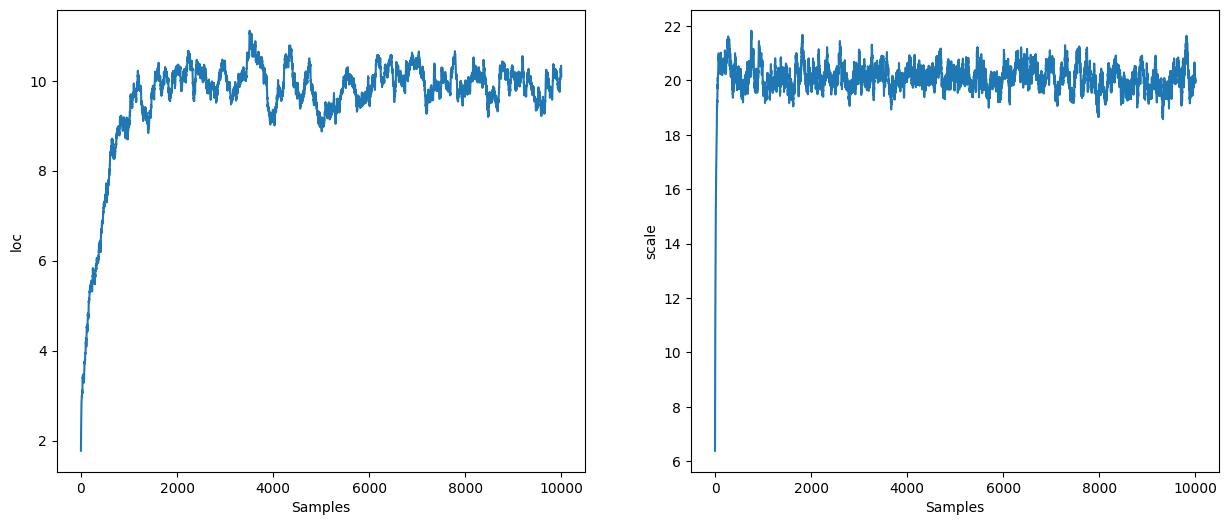

In [29]:
fig, (ax, ax1) = plt.subplots(ncols=2, figsize=(15, 6))
ax.plot(mcmc_samples["loc"])
ax.set_xlabel("Samples")
ax.set_ylabel("loc")

ax1.plot(mcmc_samples["scale"])
ax1.set_xlabel("Samples")
ax1.set_ylabel("scale");

In [30]:
inv_mass_matrix = np.array([0.5, 0.01])
step_size = 1e-3

nuts = blackjax.nuts(logdensity, step_size, inv_mass_matrix)

In [31]:
initial_position = {"loc": 1.0, "log_scale": 1.0}
initial_state = nuts.init(initial_position)
initial_state

HMCState(position={'loc': 1.0, 'log_scale': 1.0}, logdensity=Array(-34143.684, dtype=float32), logdensity_grad={'loc': Array(1170.8667, dtype=float32, weak_type=True), 'log_scale': Array(63452.48, dtype=float32, weak_type=True)})

In [32]:
%%time
rng_key, sample_key = jax.random.split(rng_key)
states = inference_loop(sample_key, nuts.step, initial_state, 4_000)

mcmc_samples = states.position
mcmc_samples["scale"] = jnp.exp(mcmc_samples["log_scale"]).block_until_ready()

CPU times: user 17.3 s, sys: 717 ms, total: 18 s
Wall time: 15.7 s


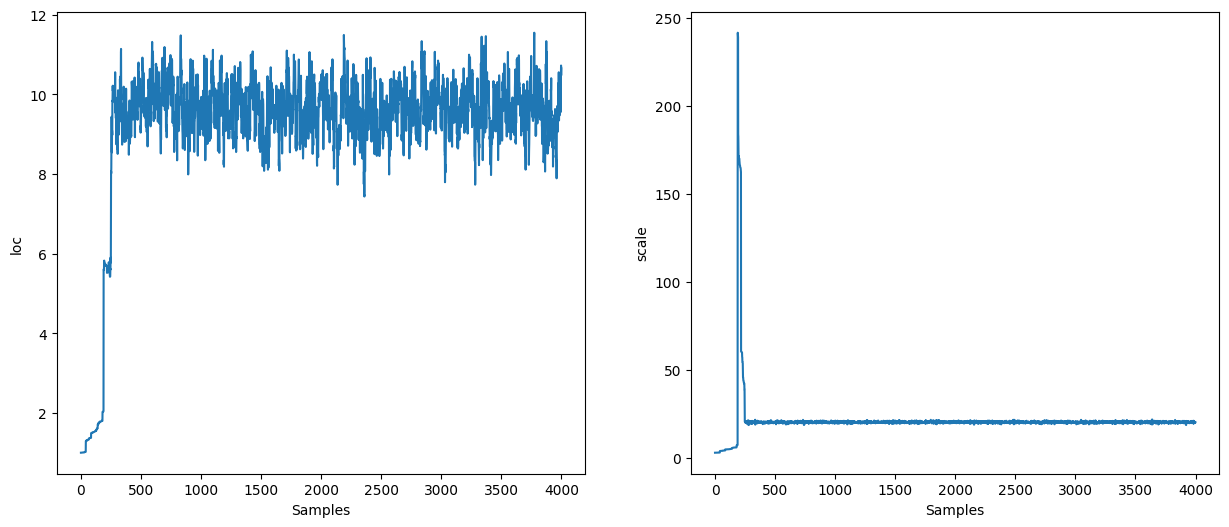

In [33]:
fig, (ax, ax1) = plt.subplots(ncols=2, figsize=(15, 6))
ax.plot(mcmc_samples["loc"])
ax.set_xlabel("Samples")
ax.set_ylabel("loc")

ax1.plot(mcmc_samples["scale"])
ax1.set_xlabel("Samples")
ax1.set_ylabel("scale");

In [34]:
%%time

warmup = blackjax.window_adaptation(blackjax.nuts, logdensity)
rng_key, warmup_key, sample_key = jax.random.split(rng_key, 3)
(state, parameters), _ = warmup.run(warmup_key, initial_position, num_steps=1000)

CPU times: user 2.41 s, sys: 136 ms, total: 2.55 s
Wall time: 1.01 s


In [35]:
%%time

kernel = blackjax.nuts(logdensity, **parameters).step
states = inference_loop(sample_key, kernel, state, 1_000)

mcmc_samples = states.position
mcmc_samples["scale"] = jnp.exp(mcmc_samples["log_scale"]).block_until_ready()

CPU times: user 1.7 s, sys: 74.8 ms, total: 1.77 s
Wall time: 657 ms


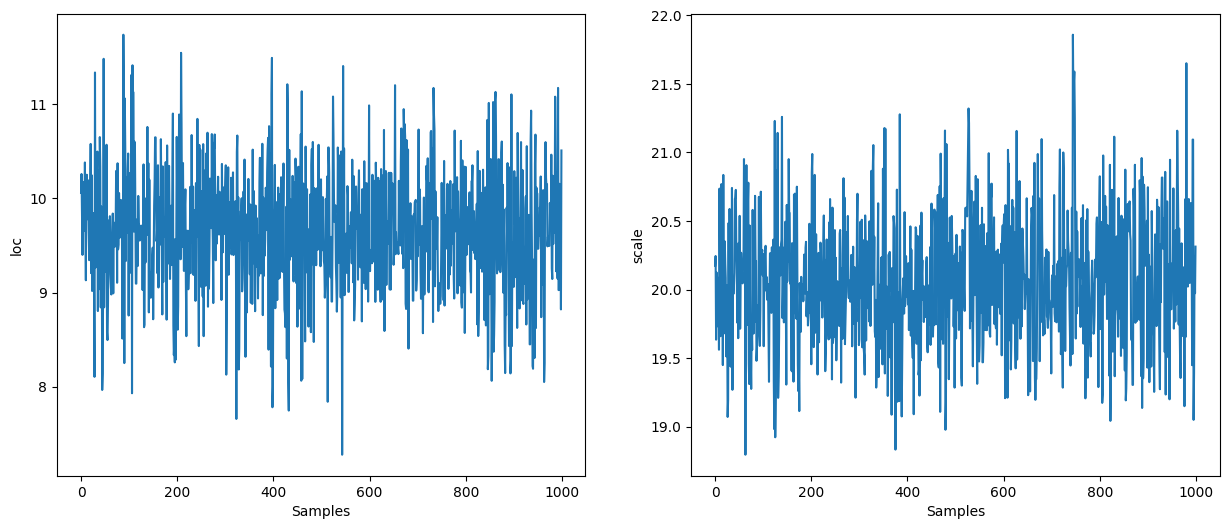

In [36]:
fig, (ax, ax1) = plt.subplots(ncols=2, figsize=(15, 6))
ax.plot(mcmc_samples["loc"])
ax.set_xlabel("Samples")
ax.set_ylabel("loc")

ax1.plot(mcmc_samples["scale"])
ax1.set_xlabel("Samples")
ax1.set_ylabel("scale");